# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [743]:
! pip install SimpleITK==1.2.2 
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

# data directory
data_dir = 'data/brain_age/'

### Running on DoC lab machines

In [2]:
# data directory
data_dir = '/vol/lab/course/416/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [744]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

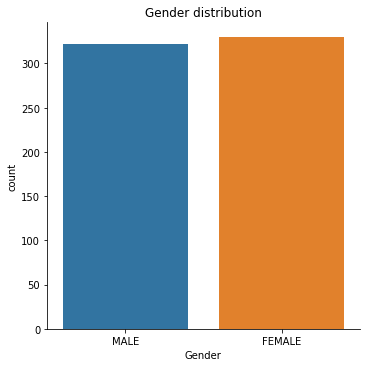

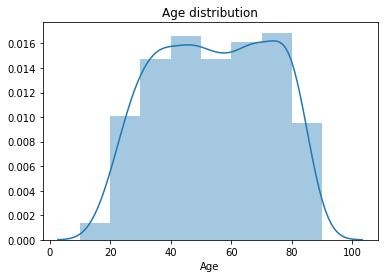

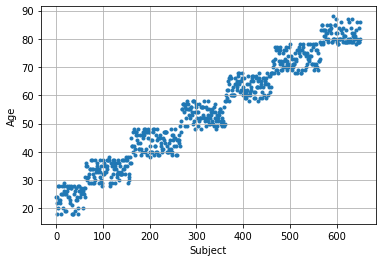

In [298]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [299]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


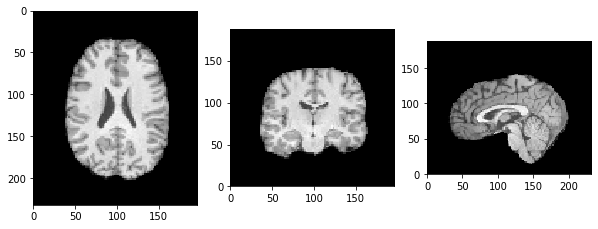

Brain mask (used in part A)


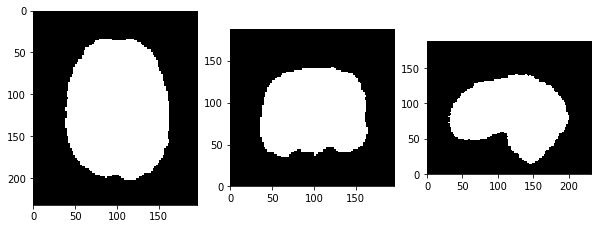

Spatially normalised grey matter maps (used in part B and C)


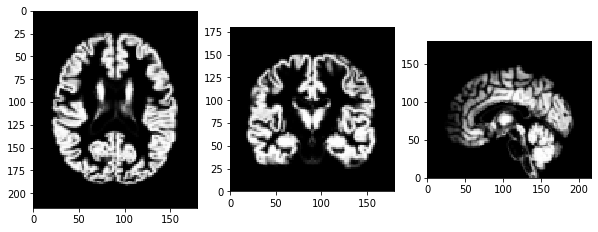

In [300]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [301]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [302]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]
    



#### Check that the GPU is up and running

In [303]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla K80


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [653]:
rnd_seed = 42 #fixed random seed

img_size = [64,64,64]
img_spacing = [2.7,2.7,2.7]

num_epochs = 100
learning_rate = 0.001
batch_size = 4
val_interval = 10

# GM, WM, CSF, and background
num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [654]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]


We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [655]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
# dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  7.46it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


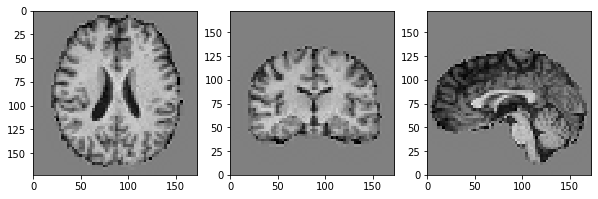

Segmentation


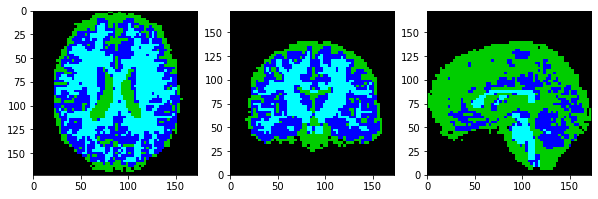

Mask


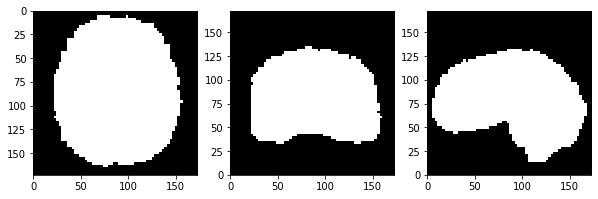

In [656]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [657]:
########################################
# BUILD A BETTER MODEL HERE
########################################

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return F.softmax(x, dim=1)

In [658]:
def double_conv_3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm=True):
    if norm:
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, 
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
        )
    else:
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, 
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
        )

class UNet3D(nn.Module):
  def __init__(self, num_classes, num_channels):
    super(UNet3D, self).__init__()
    
    self.softmax = nn.Softmax(dim=1)
    self.maxpool = nn.MaxPool3d(2)
    self.dropout = nn.Dropout3d()
    
    # First down block 
    self.down_block_1 = double_conv_3d(1, num_channels)

    # Second down block
    self.down_block_2 = double_conv_3d(num_channels, num_channels * 2)
    
    # Third down block
    self.down_block_3 = double_conv_3d(num_channels * 2, num_channels * 4)

    # Bridge
    self.bridge = double_conv_3d(num_channels * 4, num_channels * 8)
    
    # First up block
    self.conv_trans_1 = nn.Sequential(
        nn.ConvTranspose3d(num_channels * 8, num_channels * 4, kernel_size=2, stride=2),
        nn.BatchNorm3d(num_channels * 4)
    )
    self.up_block_1 = double_conv_3d(num_channels * 4, num_channels * 4)
    
    # Second up block
    self.conv_trans_2 = nn.Sequential(
        nn.ConvTranspose3d(num_channels * 4, num_channels * 2, kernel_size=2, stride=2),
        nn.BatchNorm3d(num_channels * 2)
    )
    self.up_block_2 = double_conv_3d(num_channels * 2, num_channels * 2)
    
    # Third up block
    self.conv_trans_3 = nn.Sequential(
        nn.ConvTranspose3d(num_channels * 2, num_channels, kernel_size=2, stride=2),
        nn.BatchNorm3d(num_channels)
    )
    self.up_block_3 = double_conv_3d(num_channels, num_channels)
    
    # Out
    self.out = nn.Conv3d(num_channels, num_classes, 
                         kernel_size=1, stride=1, padding=0)

  def forward(self, x):

    # Downsampling
    # First
    conv_1 = x = self.down_block_1(x)
    x = self.maxpool(conv_1)
    # Second
    conv_2  = self.down_block_2(x)
    x = self.maxpool(conv_2)
    # Third
    conv_3 = self.down_block_3(x)
    x = self.maxpool(conv_3)

    # Bridge
    x = self.bridge(x)

    # Up sampling
    # First
    x = self.conv_trans_1(x)
    x = torch.add(conv_3, x)
    x = self.up_block_1(x)
    # Second
    x = self.conv_trans_2(x)
    x = torch.add(conv_2, x)
    x = self.up_block_2(x)
    # Third
    x = self.conv_trans_3(x)
    x = torch.add(conv_1, x)
    x = self.up_block_3(x)

    x = self.out(x)
    x = self.softmax(x)

    return x

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

lr: 0.001
Total number of parameters is: 315012
START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1.370460
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 1.369394 	JI: 0.135648 	DSC: 0.238619 	HD: 22.887828 	ASD: 2.051051


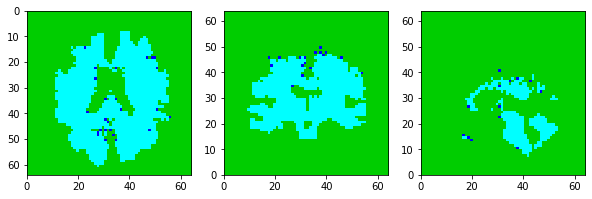

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 1.355451
+ TRAINING 	Epoch: 3 	Loss: 1.334396
+ TRAINING 	Epoch: 4 	Loss: 1.317709
+ TRAINING 	Epoch: 5 	Loss: 1.298539
+ TRAINING 	Epoch: 6 	Loss: 1.280371
+ TRAINING 	Epoch: 7 	Loss: 1.264413
+ TRAINING 	Epoch: 8 	Loss: 1.234428
+ TRAINING 	Epoch: 9 	Loss: 1.225772
+ TRAINING 	Epoch: 10 	Loss: 1.198566
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 1.194407 	JI: 0.565829 	DSC: 0.722444 	HD: 11.815161 	ASD: 0.918954


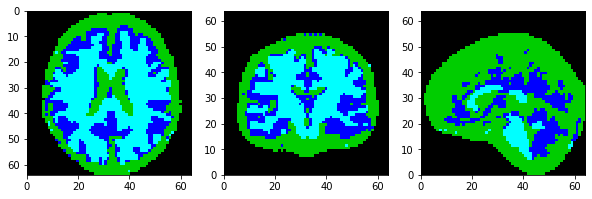

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 1.167556
+ TRAINING 	Epoch: 12 	Loss: 1.145090
+ TRAINING 	Epoch: 13 	Loss: 1.123229
+ TRAINING 	Epoch: 14 	Loss: 1.103342
+ TRAINING 	Epoch: 15 	Loss: 1.072132
+ TRAINING 	Epoch: 16 	Loss: 1.056085
+ TRAINING 	Epoch: 17 	Loss: 1.028634
+ TRAINING 	Epoch: 18 	Loss: 1.010144
+ TRAINING 	Epoch: 19 	Loss: 0.996417
+ TRAINING 	Epoch: 20 	Loss: 0.982141
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.985857 	JI: 0.681323 	DSC: 0.810327 	HD: 8.542331 	ASD: 0.523325


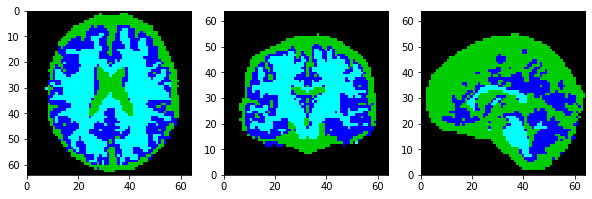

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.969615
+ TRAINING 	Epoch: 22 	Loss: 0.954480
+ TRAINING 	Epoch: 23 	Loss: 0.940614
+ TRAINING 	Epoch: 24 	Loss: 0.921970
+ TRAINING 	Epoch: 25 	Loss: 0.916170
+ TRAINING 	Epoch: 26 	Loss: 0.905269
+ TRAINING 	Epoch: 27 	Loss: 0.901432
+ TRAINING 	Epoch: 28 	Loss: 0.888199
+ TRAINING 	Epoch: 29 	Loss: 0.886498
+ TRAINING 	Epoch: 30 	Loss: 0.874801
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.876877 	JI: 0.727076 	DSC: 0.841943 	HD: 7.705056 	ASD: 0.378346


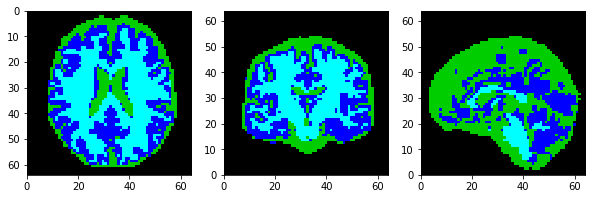

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.871389
+ TRAINING 	Epoch: 32 	Loss: 0.861960
+ TRAINING 	Epoch: 33 	Loss: 0.857649
+ TRAINING 	Epoch: 34 	Loss: 0.853811
+ TRAINING 	Epoch: 35 	Loss: 0.848580
+ TRAINING 	Epoch: 36 	Loss: 0.844652
+ TRAINING 	Epoch: 37 	Loss: 0.842144
+ TRAINING 	Epoch: 38 	Loss: 0.842721
+ TRAINING 	Epoch: 39 	Loss: 0.838539
+ TRAINING 	Epoch: 40 	Loss: 0.838366
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.836663 	JI: 0.738583 	DSC: 0.849616 	HD: 7.881052 	ASD: 0.348487


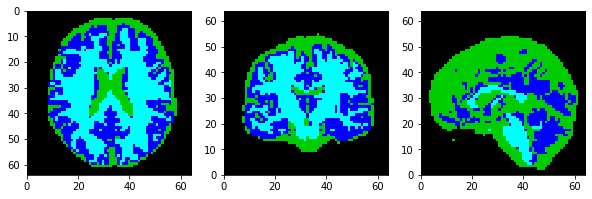

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.833180
+ TRAINING 	Epoch: 42 	Loss: 0.830185
+ TRAINING 	Epoch: 43 	Loss: 0.840879
+ TRAINING 	Epoch: 44 	Loss: 0.826046
+ TRAINING 	Epoch: 45 	Loss: 0.828834
+ TRAINING 	Epoch: 46 	Loss: 0.820307
+ TRAINING 	Epoch: 47 	Loss: 0.821318
+ TRAINING 	Epoch: 48 	Loss: 0.819253
+ TRAINING 	Epoch: 49 	Loss: 0.816204
+ TRAINING 	Epoch: 50 	Loss: 0.817878
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.822000 	JI: 0.735730 	DSC: 0.847720 	HD: 7.682457 	ASD: 0.365788


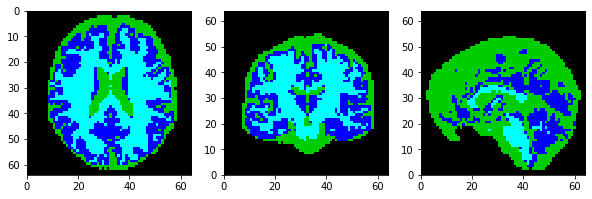

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.819192
+ TRAINING 	Epoch: 52 	Loss: 0.812911
+ TRAINING 	Epoch: 53 	Loss: 0.812361
+ TRAINING 	Epoch: 54 	Loss: 0.811662
+ TRAINING 	Epoch: 55 	Loss: 0.809475
+ TRAINING 	Epoch: 56 	Loss: 0.808708
+ TRAINING 	Epoch: 57 	Loss: 0.809274
+ TRAINING 	Epoch: 58 	Loss: 0.806899
+ TRAINING 	Epoch: 59 	Loss: 0.807765
+ TRAINING 	Epoch: 60 	Loss: 0.808122
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.811761 	JI: 0.743535 	DSC: 0.852895 	HD: 7.712179 	ASD: 0.338100


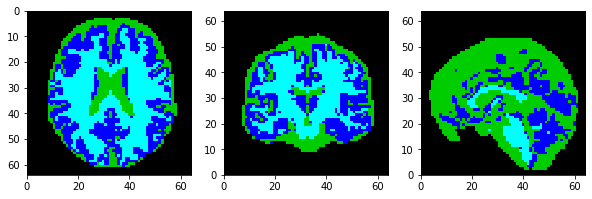

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.806215
+ TRAINING 	Epoch: 62 	Loss: 0.804047
+ TRAINING 	Epoch: 63 	Loss: 0.802612
+ TRAINING 	Epoch: 64 	Loss: 0.806213
+ TRAINING 	Epoch: 65 	Loss: 0.800831
+ TRAINING 	Epoch: 66 	Loss: 0.800407
+ TRAINING 	Epoch: 67 	Loss: 0.801577
+ TRAINING 	Epoch: 68 	Loss: 0.800565
+ TRAINING 	Epoch: 69 	Loss: 0.800003
+ TRAINING 	Epoch: 70 	Loss: 0.803947
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.807422 	JI: 0.744443 	DSC: 0.853442 	HD: 7.736526 	ASD: 0.346814


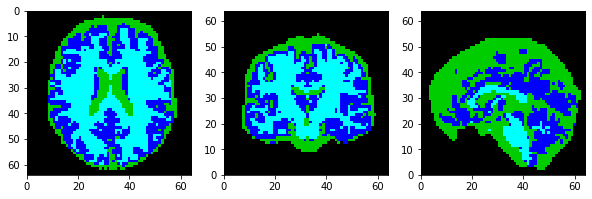

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.798061
+ TRAINING 	Epoch: 72 	Loss: 0.796584
+ TRAINING 	Epoch: 73 	Loss: 0.797742
+ TRAINING 	Epoch: 74 	Loss: 0.797480
+ TRAINING 	Epoch: 75 	Loss: 0.795096
+ TRAINING 	Epoch: 76 	Loss: 0.796800
+ TRAINING 	Epoch: 77 	Loss: 0.794971
+ TRAINING 	Epoch: 78 	Loss: 0.794497
+ TRAINING 	Epoch: 79 	Loss: 0.798659
+ TRAINING 	Epoch: 80 	Loss: 0.796131
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.802991 	JI: 0.750414 	DSC: 0.857389 	HD: 7.933072 	ASD: 0.330009


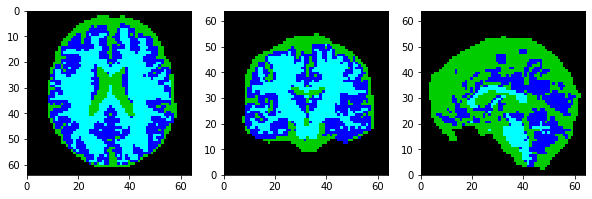

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.796687
+ TRAINING 	Epoch: 82 	Loss: 0.795887
+ TRAINING 	Epoch: 83 	Loss: 0.796231
+ TRAINING 	Epoch: 84 	Loss: 0.803311
+ TRAINING 	Epoch: 85 	Loss: 0.794968
+ TRAINING 	Epoch: 86 	Loss: 0.793899
+ TRAINING 	Epoch: 87 	Loss: 0.797756
+ TRAINING 	Epoch: 88 	Loss: 0.793538
+ TRAINING 	Epoch: 89 	Loss: 0.796021
+ TRAINING 	Epoch: 90 	Loss: 0.792997
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.800972 	JI: 0.750950 	DSC: 0.857716 	HD: 8.052030 	ASD: 0.326548


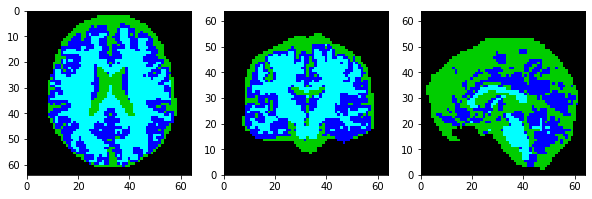

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.791775
+ TRAINING 	Epoch: 92 	Loss: 0.791673
+ TRAINING 	Epoch: 93 	Loss: 0.789693
+ TRAINING 	Epoch: 94 	Loss: 0.792813
+ TRAINING 	Epoch: 95 	Loss: 0.790299
+ TRAINING 	Epoch: 96 	Loss: 0.791711
+ TRAINING 	Epoch: 97 	Loss: 0.788881
+ TRAINING 	Epoch: 98 	Loss: 0.789462
+ TRAINING 	Epoch: 99 	Loss: 0.788587
+ TRAINING 	Epoch: 100 	Loss: 0.793345
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.799412 	JI: 0.752714 	DSC: 0.858879 	HD: 7.811793 	ASD: 0.320342


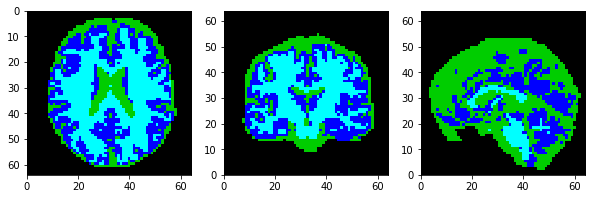

--------------------------------------------------

Finished TRAINING.


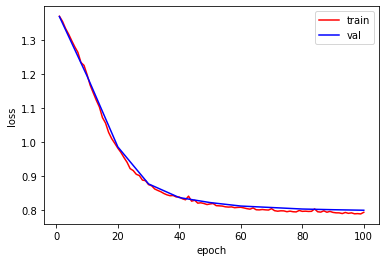

In [659]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

print('learning rate:', learning_rate)
torch.cuda.empty_cache()
model = UNet3D(num_classes=num_classes, num_channels=8).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()
        del img
        del seg

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        num_val = 0
        ji_val = 0
        dsc_val = 0
        hd_val = 0
        asd_val = 0

        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)

                prediction = sitk.GetImageFromArray(torch.argmax(prd, dim=1).cpu().squeeze().numpy().astype(np.int64))
                prediction.CopyInformation(sample['seg'])

                reference = dataset_val.get_sample(num_val)['seg']
                overlap_measures_filter.Execute(reference, prediction)
                hausdorff_distance_filter.Execute(sitk.LabelContour(reference), sitk.LabelContour(prediction))

                ji_val += overlap_measures_filter.GetJaccardCoefficient()
                dsc_val += overlap_measures_filter.GetDiceCoefficient()
                hd_val += hausdorff_distance_filter.GetHausdorffDistance()
                asd_val += hausdorff_distance_filter.GetAverageHausdorffDistance()
                num_val += 1
                del img
                del seg

        ji_val /= num_val
        dsc_val /= num_val
        hd_val /= num_val
        asd_val /= num_val

        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tJI: {:.6f} \tDSC: {:.6f} \tHD: {:.6f} \tASD: {:.6f}'.format(epoch, loss_val, ji_val, dsc_val, hd_val, asd_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))
del model
print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [755]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])

# Use Test Dataset
#meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
#ids_seg_test = list(meta_data_reg_test['subject_id'])

files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


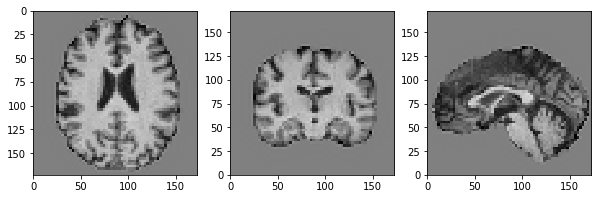

Segmentation


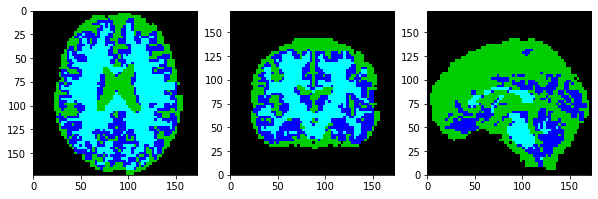

Mask


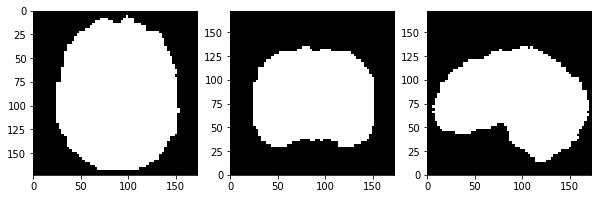

In [756]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.801897 	JI: 0.745094 	DSC: 0.853667 	HD: 8.446862 	ASD: 0.320150


Reference segmentation


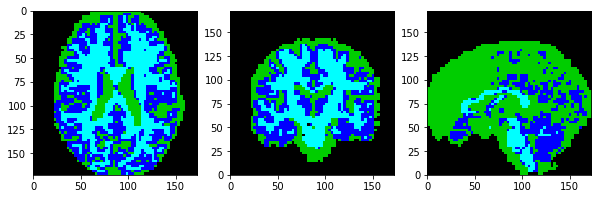

Predicted segmentation


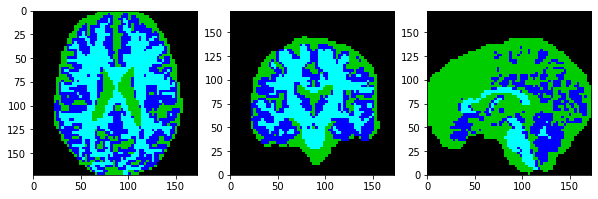


Finished TESTING.


In [757]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model_dir = os.path.join(out_dir, 'model')
model = UNet3D(num_classes=num_classes, num_channels=8).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
ji_test = 0
dsc_tests = []
hd_test = 0
asd_test = 0
# Background
back_dsc = []
# CSF
csf_dsc = []
# GM
gm_dsc = []
# Wm
wm_dsc = []
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.int64))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        reference = dataset_test.get_sample(idx_test)['seg']
        # Background
        overlap_measures_filter.Execute(reference==0, prediction==0)
        back_dsc.append(overlap_measures_filter.GetDiceCoefficient())
        # CSF
        overlap_measures_filter.Execute(reference==1, prediction==1)
        csf_dsc.append(overlap_measures_filter.GetDiceCoefficient())
        # GM
        overlap_measures_filter.Execute(reference==2, prediction==2)
        gm_dsc.append(overlap_measures_filter.GetDiceCoefficient())
        # WN
        overlap_measures_filter.Execute(reference==3, prediction==3)
        wm_dsc.append(overlap_measures_filter.GetDiceCoefficient())
        # Overall
        overlap_measures_filter.Execute(reference, prediction)
        hausdorff_distance_filter.Execute(sitk.LabelContour(reference), sitk.LabelContour(prediction))
                    
        ji_test += overlap_measures_filter.GetJaccardCoefficient()
        dsc_tests.append(overlap_measures_filter.GetDiceCoefficient())
        hd_test += hausdorff_distance_filter.GetHausdorffDistance()
        asd_test += hausdorff_distance_filter.GetAverageHausdorffDistance()
        
        idx_test += 1
        
loss_test /= sum_pts
ji_test /= idx_test
dsc_test = sum(dsc_tests)/idx_test
hd_test /= idx_test
asd_test /= idx_test

print('+ TESTING \tLoss: {:.6f} \tJI: {:.6f} \tDSC: {:.6f} \tHD: {:.6f} \tASD: {:.6f}'.format(loss_test, ji_test, dsc_test, hd_test, asd_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2dae238e48>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2dae238550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2dae238ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2de1d0fbe0>],
 'fliers': [],
 'means': []}

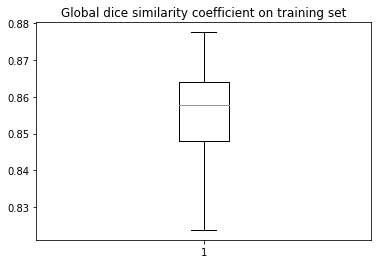

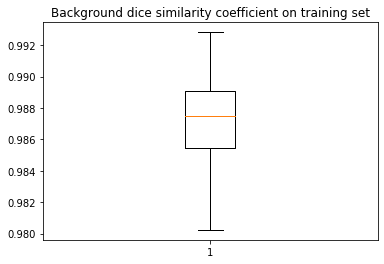

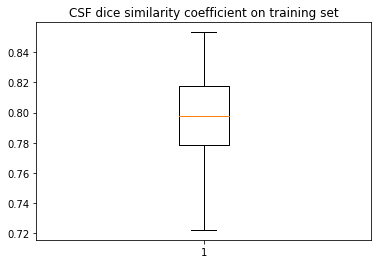

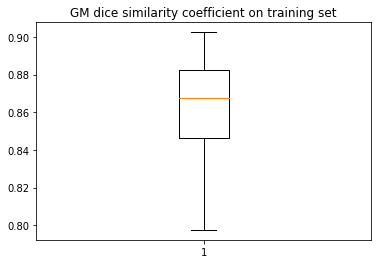

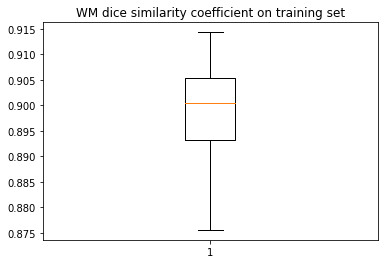

In [758]:
# Overall dice similarity coefficient
fig1, ax1 = plt.subplots()
ax1.set_title('Global dice similarity coefficient on training set')
ax1.boxplot(dsc_tests, showfliers=False)

# Background similarity coefficient
fig2, ax2 = plt.subplots()
ax2.set_title('Background dice similarity coefficient on training set')
ax2.boxplot(back_dsc, showfliers=False)
# CSF dice similarity coefficient
fig3, ax3 = plt.subplots()
ax3.set_title('CSF dice similarity coefficient on training set')
ax3.boxplot(csf_dsc, showfliers=False)
# GM dice similarity coefficient
fig4, ax4 = plt.subplots()
ax4.set_title('GM dice similarity coefficient on training set')
ax4.boxplot(gm_dsc, showfliers=False)
# WM dice similarity coefficient
fig5, ax5 = plt.subplots()
ax5.set_title('WM dice similarity coefficient on training set')
ax5.boxplot(wm_dsc, showfliers=False)


### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [767]:
## CALCULATE ABSOLUTE TISSUE VOLUMES
import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
# seg_dir = data_dir + 'segs_refs/'

# Use the training data
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])

files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        seg_data = sitk.GetArrayFromImage(seg).flatten()
        vols[0, idx] = seg_data[seg_data == 1].shape[0]
        vols[1, idx] = seg_data[seg_data == 2].shape[0]
        vols[2, idx] = seg_data[seg_data == 3].shape[0]
        
# Use Test Dataset
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])

files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols_test = np.zeros((3,len(files_reg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        seg_data = sitk.GetArrayFromImage(seg).flatten()
        vols_test[0, idx] = seg_data[seg_data == 1].shape[0]
        vols_test[1, idx] = seg_data[seg_data == 2].shape[0]
        vols_test[2, idx] = seg_data[seg_data == 3].shape[0]

Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 131.72it/s]


Plot features versus age.

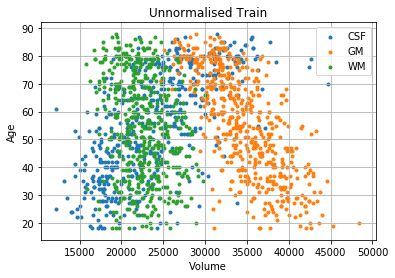

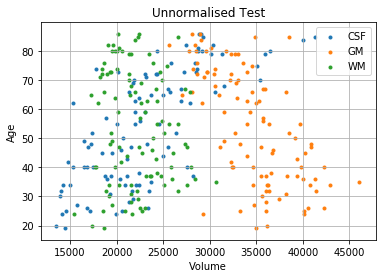

In [768]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised Train')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

plt.scatter(vols_test[0,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_test[1,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_test[2,:],meta_data_reg_test['age'], marker='.')
plt.grid()
plt.title('Unnormalised Test')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [769]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))
vols_test_normalised = np.zeros((3,len(files_reg_seg_test)))

########################################
# ADD YOUR CODE HERE
########################################
vols_normalised = vols / vols.sum(axis=0)
vols_test_normalised = vols_test / vols_test.sum(axis=0)

Plot normalised features versus age.

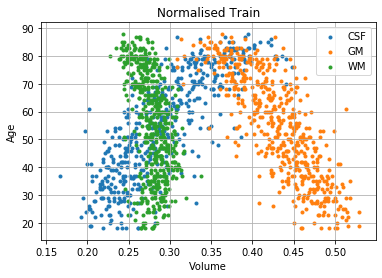

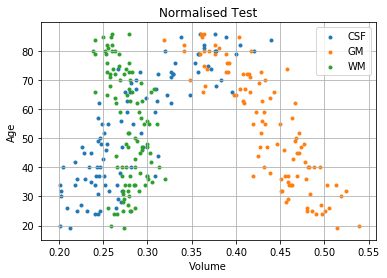

In [770]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised Train')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

plt.scatter(vols_test_normalised[0,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_test_normalised[1,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_test_normalised[2,:],meta_data_reg_test['age'], marker='.')
plt.grid()
plt.title('Normalised Test')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [771]:
# Train
X = vols_normalised.T
#X = np.array([X[:, 0], np.add(X[:, 1], X[:, 2])]).T
y = meta_data_reg_train['age'].values.reshape(-1,1)
print(X.shape)
print(y.shape)

# Test
X_test = vols_test_normalised.T
#X_test = np.array([X_test[:, 0], np.add(X_test[:, 1], X_test[:, 2])]).T
y_test = meta_data_reg_test['age'].values.reshape(-1,1)
print(X_test.shape)
print(y_test.shape)

(500, 3)
(500, 1)
(100, 3)
(100, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

Lin Regression  |  MAE:  8.65636328125 | R2 score:  0.6405956486420101
Bays Ridge  |  MAE:  8.658493678180081 | R2 score:  0.6407271619796858
Ridge  |  MAE:  8.782647216334464 | R2 score:  0.6388169809127177
Lasso  |  MAE:  9.025436985120018 | R2 score:  0.6246465860629977
El Net  |  MAE:  15.78284513266706 | R2 score:  0.007615437028056671
Reg Tree  |  MAE:  10.888000000000002 | R2 score:  0.3945617525801422
SVR rbf  |  MAE:  8.68992005412035 | R2 score:  0.6475046772915218
SVR poly  |  MAE:  8.197838793863813 | R2 score:  0.6640468400186774


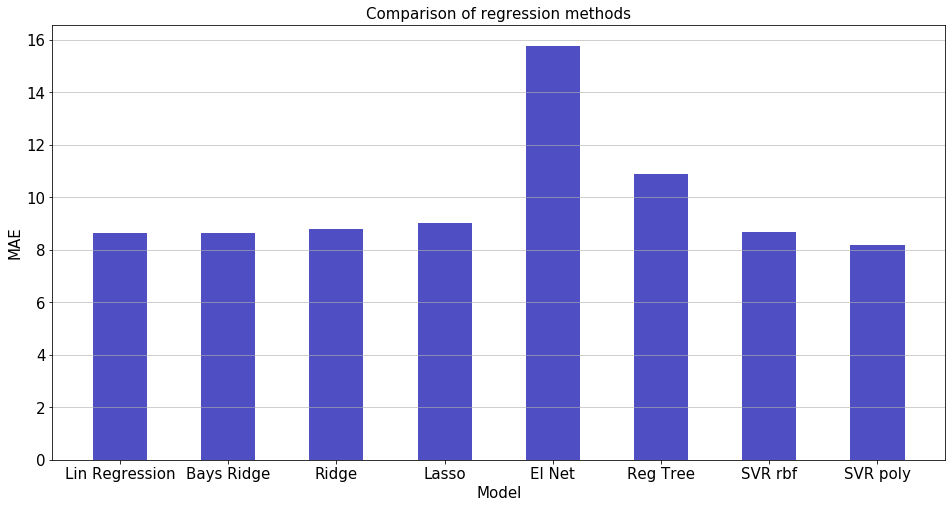

In [773]:
########################################
# ADD YOUR CODE HERE
########################################
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# First we shuffle the data
X_shuffled, y_shuffled = shuffle(X, y.reshape(-1))

# Scoring
scoring = {'MAE': make_scorer(mean_absolute_error), 'r2': 'r2'}

scores = []
models = []
def cross_validation_model(model, name):
    # Cross validation on linear regression
    cv = cross_validate(estimator=model, 
                           X=X_shuffled, y=y_shuffled, 
                           cv=2, scoring=scoring)
    MAE = sum(cv['test_MAE']) / 2
    r2_score = sum(cv['test_r2']) / 2
    print(name, " |  MAE: ", MAE, "| R2 score: ", r2_score)
    scores.append(MAE)
    models.append(name)
    
# Linear regression
cross_validation_model(linear_model.LinearRegression(), "Lin Regression")
# Bayesian Ridge
cross_validation_model(linear_model.BayesianRidge(), "Bays Ridge")
# Ridge (L2 regularisation)
cross_validation_model(linear_model.Ridge(0.1), "Ridge")
# Lasso (L1 regularisation)
cross_validation_model(linear_model.Lasso(alpha=0.1), "Lasso")
# Elastic net (L1 and L2 regularisation)
cross_validation_model(linear_model.ElasticNet(0.5, 0.2), "El Net")
# Regression Tree
cross_validation_model(DecisionTreeRegressor(), "Reg Tree")
# SVR
cross_validation_model(SVR(kernel='rbf'), "SVR rbf")
cross_validation_model(SVR(kernel='poly'), "SVR poly")

# Plot results
plt.figure(figsize=[16,8])
plt.bar(models, scores, width = 0.5, color='#0504aa',alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Model',fontsize=15)
plt.ylabel('MAE',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Comparison of regression methods',fontsize=15)
plt.show()


Error calculation and plotting

mean absolute error: 7.87906319753198
r2 score: 0.7558268112536578
explained variance: 0.7566680405598183


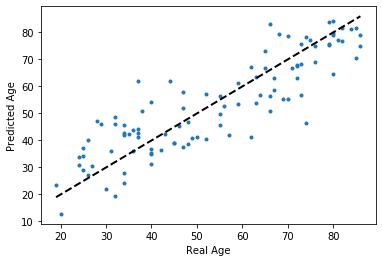

In [774]:
def evaluate(y, predicted):
    print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
    print('r2 score: {0}'.format(r2_score(y,predicted)))
    print('explained variance: {0}'.format(explained_variance_score(y,predicted)))
    
    fig, ax = plt.subplots()
    ax.scatter(y, predicted, marker='.')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')
    plt.show()

# We train the best model from CV
model = SVR(kernel='poly', C=1)
model.fit(X=X_shuffled, y=y_shuffled)
predictions = model.predict(X_test)

# Evaluate test set
evaluate(y_test, predictions)

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

Before pre-processing


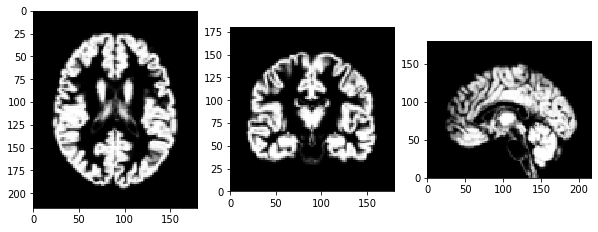

After pre-processing


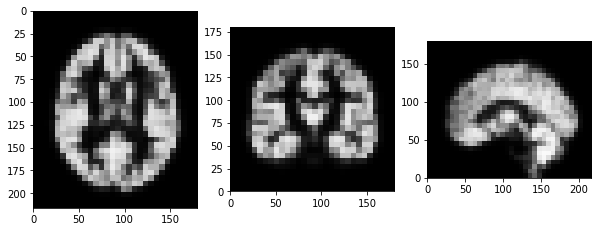

Pre-process training set
Pre-process test set
Finished processing


In [736]:
########################################
# ADD YOUR CODE HERE
########################################
import glob 

# This class handles smoothing and downsampling
class ImageProcessor():
    def __init__(self, image, factor=3):
        self.image = image
        self.factor = factor
    def smooth_image(self):
        self.image = sitk.GradientAnisotropicDiffusion(self.image)
    def downsample_image(self):
        gaussian_pyramid = sitk.DiscreteGaussian(self.image, (0.5 * self.factor) ** 2)
        self.image = gaussian_pyramid[::self.factor, ::self.factor, ::self.factor]
    def process(self):
        self.downsample_image()
        self.smooth_image()
        return self.image
    
# Shows an example image before and after pre-processing
print('Before pre-processing')
display_image(gm)


print('After pre-processing')
display_image(ImageProcessor(gm).process())

# Pre-process training set
print("Pre-process training set")
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_gm = list(meta_data_reg_train['subject_id'])
gm_files = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_gm]


idx = 0
processing_dir = './processed/'
if not os.path.exists(os.path.dirname(processing_dir)):
    os.makedirs(os.path.dirname(processing_dir))
    
for file in gm_files:
    processed_image_path = processing_dir + meta_data_reg_train['subject_id'].values[idx] + '.nii.gz'
    gm = sitk.ReadImage(file)
    processed_image = ImageProcessor(gm).process()
    sitk.WriteImage(processed_image, processed_image_path)
    idx += 1
    
    
# Pre-process test set
print("Pre-process test set")
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_gm = list(meta_data_reg_test['subject_id'])
gm_files_test = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_gm]


idx = 0
processing_dir = './processed/'
if not os.path.exists(os.path.dirname(processing_dir)):
    os.makedirs(os.path.dirname(processing_dir))
    
for file in gm_files_test:
    processed_image_path = processing_dir + meta_data_reg_test['subject_id'].values[idx] + '.nii.gz'
    gm = sitk.ReadImage(file)
    processed_image = ImageProcessor(gm).process()
    sitk.WriteImage(processed_image, processed_image_path)
    idx += 1
        
print('Finished pre-processing')



In [775]:
# Load training set
print("Training set")
img_data = []
idx = 0
for file in gm_files:
    image_path = processing_dir + meta_data_reg_train['subject_id'].values[idx] + '.nii.gz'
    image = sitk.ReadImage(image_path)
    img_data.append(sitk.GetArrayFromImage(image))
    idx += 1
img_data = np.array(img_data)
img_data = img_data.reshape(img_data.shape[0], -1)
X = img_data
y = meta_data_reg_train['age'].values.reshape(-1,1)

print("Load test set")
# Load test set
img_data = []
idx = 0
for file in gm_files_test:
    image_path = processing_dir + meta_data_reg_test['subject_id'].values[idx] + '.nii.gz'
    image = sitk.ReadImage(image_path)
    img_data.append(sitk.GetArrayFromImage(image))
    idx += 1
img_data = np.array(img_data)
img_data = img_data.reshape(img_data.shape[0], -1)
X_test = img_data
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

print("Traning set shapes")
print(X.shape)
print(y.shape)

print("Test set shapes")
print(X_test.shape)
print(y_test.shape)

Training set
Load test set
Traning set shapes
(500, 32400)
(500, 1)
Test set shapes
(100, 32400)
(100, 1)


### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [776]:
########################################
# ADD YOUR CODE HERE
########################################
from sklearn.decomposition import PCA

def perform_pca(X_train, X_test):
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    return pca.transform(X_train), pca.transform(X_test)
    

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

Lin Regression  |  MAE:  5.380690692901611 | R2 score:  0.865844950010858
Bays Ridge  |  MAE:  5.5291495770532455 | R2 score:  0.855120968670489
Ridge  |  MAE:  5.206827713012695 | R2 score:  0.8716945466596067
Lasso  |  MAE:  5.645982707977295 | R2 score:  0.8511027221336327
El Net  |  MAE:  5.49409175491333 | R2 score:  0.8593869776517201
Reg Tree  |  MAE:  9.33 | R2 score:  0.574123156222405
SVR rbf  |  MAE:  7.361116985863868 | R2 score:  0.7591819426194477
SVR poly  |  MAE:  11.90543643607154 | R2 score:  0.37932022086507394


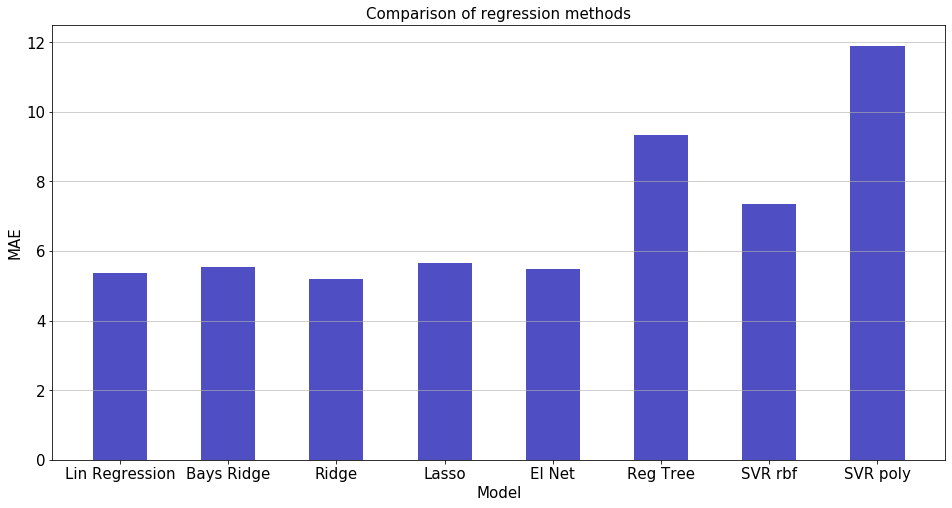

In [887]:
########################################
# ADD YOUR CODE HERE
########################################
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold

# Metrics
scores = []
models = []

# First we shuffle the data
X_shuffled, y_shuffled = shuffle(X, y.reshape(-1))

class CrossValidationPCA():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.models = {}
        
    def register_model(self, model, name):
        self.models[name] = model

    def run(self):
        for name, model in self.models.items():
            # Metrics
            mae = 0
            r2 = 0
            # Folds with shuffle
            k_fold = KFold(n_splits = 2, shuffle = True)
            for train_idx, test_idx in k_fold.split(self.X):
                # Create training and testing set
                X_train, X_test, y_train, y_test = self.X[train_idx], self.X[test_idx], self.y[train_idx], self.y[test_idx]
                # Perform PCA on features sets
                X_train, X_test = perform_pca(X_train, X_test)
                # Fit the model
                model.fit(X_train, y_train)
                # Predict data
                predicted = model.predict(X_test)
                # Compute metrics for this fold
                mae += mean_absolute_error(y_test, predicted)
                r2 += r2_score(y_test, predicted)
            
            # Average metrics
            mae /= 2
            r2 /= 2
            # Print performances
            print(name, " |  MAE: ", mae, "| R2 score: ", r2)
            scores.append(mae)
            models.append(name)
    
cross_validation = CrossValidationPCA(X_shuffled, y_shuffled)
# Linear regression
cross_validation.register_model(linear_model.LinearRegression(), "Lin Regression")
# Bayesian Ridge
cross_validation.register_model(linear_model.BayesianRidge(), "Bays Ridge")
# Ridge (L2 regularisation)
cross_validation.register_model(linear_model.Ridge(0.9), "Ridge")
# Lasso (L1 regularisation)
cross_validation.register_model(linear_model.Lasso(alpha=0.1), "Lasso")
# Elastic net (L1 and L2 regularisation)
cross_validation.register_model(linear_model.ElasticNet(0.1, 0.1), "El Net")
# Regression Tree
cross_validation.register_model(DecisionTreeRegressor(), "Reg Tree")
# SVR
cross_validation.register_model(SVR(kernel='rbf'), "SVR rbf")
cross_validation.register_model(SVR(kernel='poly'), "SVR poly")

# Run cross validation
cross_validation.run()

# Plot results
plt.figure(figsize=[16,8])
plt.bar(models, scores, width = 0.5, color='#0504aa',alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Model',fontsize=15)
plt.ylabel('MAE',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Comparison of regression methods',fontsize=15)
plt.show()

Error calculation and plotting

mean absolute error: 5.273112850189209
r2 score: 0.8967658580309243
explained variance: 0.8977302388089683


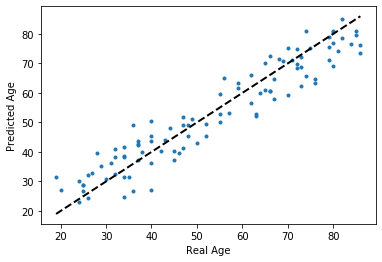

In [888]:
def evaluate(y, predicted):
    print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
    print('r2 score: {0}'.format(r2_score(y,predicted)))
    print('explained variance: {0}'.format(explained_variance_score(y,predicted)))
    
    fig, ax = plt.subplots()
    ax.scatter(y, predicted, marker='.')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')
    plt.show()

# We train the best model from CV
X_train_pca, X_test_pca = perform_pca(X_shuffled, X_test)
model = linear_model.Ridge(0.9)
model.fit(X=X_train_pca, y=y_shuffled)
predictions = model.predict(X_test_pca)

# Evaluate test set
evaluate(y_test, predictions)

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

In [256]:
########################################
# ADD YOUR CODE HERE
########################################

In [813]:
# Use training dataset for regression
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])

files_reg_train = [processing_dir + f + '.nii.gz' for f in ids_reg_train]

In [814]:
# Define dataset class


class GreyMatterDataset(Dataset):
    """Dataset for grey matter."""

    def __init__(self, file_list_img, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            img = sitk.ReadImage(img_path)
            
            #pre=processing
            img = resample_image(img, img_spacing, img_size, is_label=False)
            # Save also the index of the image, used to determine ground truth age
            sample = {'idx': idx, 'img': img}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]
        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        return {'idx': sample['idx'], 'img': image}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]



In [815]:
# Setup network parameters
rnd_seed = 42 #fixed random seed

img_size = [64,64,64]
img_spacing = [2.7,2.7,2.7]

num_epochs = 150
learning_rate = 0.0008
batch_size = 32
val_interval = 10

out_dir = './output-c'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [841]:
# Load data for regression

# Define the dataset
dataset = GreyMatterDataset(files_reg_train, img_spacing, img_size)

# Prepare cross-validation indexes
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.5 * num_train))

# Shuffle
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)



# Define the dataloaders for the cross-validation folds
dataloader_folds = []
dataloader_folds.append(torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler))

dataloader_folds.append(torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler))

Loading Data: 100%|██████████| 500/500 [00:22<00:00, 22.37it/s]


Image: CC520745.nii.gz


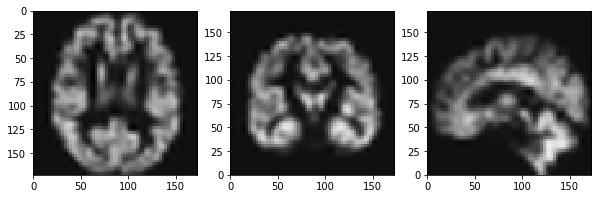

In [842]:
# Show a sample of the training dataset
sample = dataset.get_sample(0)
img_name = dataset.get_img_name(0)
print('Image: ' + img_name)
display_image(sample['img'])

# Get the target ages for the whole training dataset
y = np.array(list(meta_data_reg_train['age']))

In [843]:
# Define the brain age regression network

# Define a single convolutional sequence of layers, that uses Conv3d, BatchNorm3d, optionally MaxPool3d, and
# uses ReLu activation.
def single_conv_3d(in_channels, out_channels, kernel_size=3, padding=0, max_pool=True):
  if max_pool is True: 
    return nn.Sequential(
        nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm3d(num_features=out_channels),
        nn.MaxPool3d(2, stride=2),
        nn.ReLU()
    )
  else:
    return nn.Sequential(
        nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm3d(num_features=out_channels),
        nn.ReLU()
    )

class BrainAgeRegressor(nn.Module):
    def __init__(self, num_age_bins, min_age, max_age):
        super(BrainAgeRegressor, self).__init__()
        
        self.num_age_bins = num_age_bins
        self.min_age = min_age
        self.max_age = max_age
        
        self.extractor = nn.Sequential()
        
        # Define the feature extractor, using convolutional blocks
        self.extractor.add_module('conv_1', single_conv_3d(in_channels=1, out_channels=16, kernel_size=3, max_pool=True, padding=1))
        self.extractor.add_module('conv_2', single_conv_3d(in_channels=16, out_channels=32, kernel_size=3, max_pool=True, padding=1))
        self.extractor.add_module('conv_3', single_conv_3d(in_channels=32, out_channels=64, kernel_size=3, max_pool=True, padding=1))
        self.extractor.add_module('conv_4', single_conv_3d(in_channels=64, out_channels=128, kernel_size=3, max_pool=True, padding=1))
        self.extractor.add_module('conv_5', single_conv_3d(in_channels=128, out_channels=128, kernel_size=3, max_pool=True, padding=1))
        self.extractor.add_module('conv_6', single_conv_3d(in_channels=128, out_channels=32, kernel_size=1, max_pool=False, padding=0))
        
        # Define the classifier, which is composed of average pooling, drop-out and 3d convolution using a kernel size of 1
        self.classifier = nn.Sequential()
        self.classifier.add_module('avg_pool', nn.AvgPool3d([2, 2, 2]))
        self.classifier.add_module('dropout', nn.Dropout(0.4))
        self.classifier.add_module('out_conv', nn.Conv3d(in_channels=32, out_channels=self.num_age_bins, kernel_size=1, padding=0))



        
    def forward(self, x):
        x = self.extractor(x)
        x = self.classifier(x)
        x = F.softmax(x, dim=1)
        # Flatten the output
        x = x.view(-1,self.num_age_bins)
        # At this point, x is a vector of probabilities for each of the age bins
        # We define the age space, which is simply a vector of ages
        age_space = torch.arange(self.min_age, self.max_age, 1.0).view(-1,1).to(device)
        # To get the prediction, we multiply the probability of the age with the age value
        age_prediction = torch.matmul(x, age_space)
        return age_prediction


learning rate: 0.0008
START TRAINING FOLD 1
+ TRAINING 	Epoch: 1 	Loss: 197.068253 	MAE: 11.781563
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 248.005920 	MAE: 13.619789
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 182.054672 	MAE: 11.637104
+ TRAINING 	Epoch: 3 	Loss: 115.192375 	MAE: 9.670648
+ TRAINING 	Epoch: 4 	Loss: 209.594193 	MAE: 12.947818
+ TRAINING 	Epoch: 5 	Loss: 69.193054 	MAE: 7.335350
+ TRAINING 	Epoch: 6 	Loss: 77.713089 	MAE: 7.483120
+ TRAINING 	Epoch: 7 	Loss: 68.919724 	MAE: 6.666667
+ TRAINING 	Epoch: 8 	Loss: 59.455589 	MAE: 5.988275
+ TRAINING 	Epoch: 9 	Loss: 57.044888 	MAE: 6.464974
+ TRAINING 	Epoch: 10 	Loss: 21.993219 	MAE: 4.005360
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 79.127892 	MAE: 7.363905
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 20.770054 	MAE: 3.977954
+ TRAINING 	Epoch: 12 	Loss: 14.032605 	MAE: 3.0838

+ TRAINING 	Epoch: 118 	Loss: 26.373207 	MAE: 4.410437
+ TRAINING 	Epoch: 119 	Loss: 14.800373 	MAE: 3.357446
+ TRAINING 	Epoch: 120 	Loss: 9.240236 	MAE: 2.492613
--------------------------------------------------
+ VALIDATE 	Epoch: 120 	Loss: 53.048798 	MAE: 5.710728
--------------------------------------------------
+ TRAINING 	Epoch: 121 	Loss: 9.841921 	MAE: 2.632124
+ TRAINING 	Epoch: 122 	Loss: 11.550371 	MAE: 2.449298
+ TRAINING 	Epoch: 123 	Loss: 12.181664 	MAE: 2.660071
+ TRAINING 	Epoch: 124 	Loss: 17.221758 	MAE: 3.281628
+ TRAINING 	Epoch: 125 	Loss: 15.136140 	MAE: 3.241868
+ TRAINING 	Epoch: 126 	Loss: 10.471972 	MAE: 2.602000
+ TRAINING 	Epoch: 127 	Loss: 14.323050 	MAE: 3.073692
+ TRAINING 	Epoch: 128 	Loss: 15.097917 	MAE: 3.217543
+ TRAINING 	Epoch: 129 	Loss: 8.561548 	MAE: 2.299433
+ TRAINING 	Epoch: 130 	Loss: 9.783587 	MAE: 2.551557
--------------------------------------------------
+ VALIDATE 	Epoch: 130 	Loss: 55.862278 	MAE: 5.755692
--------------------------

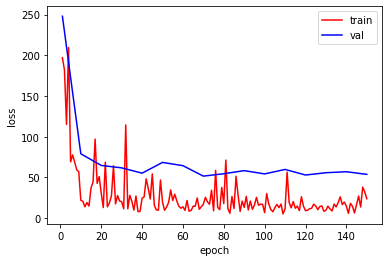

START TRAINING FOLD 2
+ TRAINING 	Epoch: 1 	Loss: 323.968689 	MAE: 15.725912
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 217.836914 	MAE: 12.564868
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 173.303925 	MAE: 11.201649
+ TRAINING 	Epoch: 3 	Loss: 202.726791 	MAE: 11.202416
+ TRAINING 	Epoch: 4 	Loss: 132.483719 	MAE: 9.514396
+ TRAINING 	Epoch: 5 	Loss: 140.640289 	MAE: 10.514641
+ TRAINING 	Epoch: 6 	Loss: 86.880341 	MAE: 7.984492
+ TRAINING 	Epoch: 7 	Loss: 63.958931 	MAE: 6.669885
+ TRAINING 	Epoch: 8 	Loss: 101.699356 	MAE: 8.199687
+ TRAINING 	Epoch: 9 	Loss: 23.116220 	MAE: 3.629705
+ TRAINING 	Epoch: 10 	Loss: 68.723656 	MAE: 7.129818
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 63.097294 	MAE: 6.375319
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 18.854654 	MAE: 3.575459
+ TRAINING 	Epoch: 12 	Loss: 33.145718 	MAE: 4.313175
+ TRAINING 	Epoc

+ TRAINING 	Epoch: 118 	Loss: 9.655847 	MAE: 2.580868
+ TRAINING 	Epoch: 119 	Loss: 12.332543 	MAE: 3.214726
+ TRAINING 	Epoch: 120 	Loss: 12.113299 	MAE: 2.779821
--------------------------------------------------
+ VALIDATE 	Epoch: 120 	Loss: 54.479450 	MAE: 5.887691
--------------------------------------------------
+ TRAINING 	Epoch: 121 	Loss: 17.153849 	MAE: 3.419534
+ TRAINING 	Epoch: 122 	Loss: 8.231503 	MAE: 2.404501
+ TRAINING 	Epoch: 123 	Loss: 17.019480 	MAE: 3.522626
+ TRAINING 	Epoch: 124 	Loss: 6.193529 	MAE: 2.100921
+ TRAINING 	Epoch: 125 	Loss: 13.537805 	MAE: 3.075555
+ TRAINING 	Epoch: 126 	Loss: 10.553141 	MAE: 2.667861
+ TRAINING 	Epoch: 127 	Loss: 13.164843 	MAE: 2.765191
+ TRAINING 	Epoch: 128 	Loss: 28.917051 	MAE: 4.643468
+ TRAINING 	Epoch: 129 	Loss: 11.076446 	MAE: 2.503569
+ TRAINING 	Epoch: 130 	Loss: 9.151743 	MAE: 2.485929
--------------------------------------------------
+ VALIDATE 	Epoch: 130 	Loss: 56.100269 	MAE: 5.936917
--------------------------

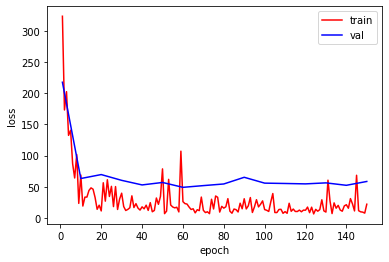

--------------------------------------------------
+ CROSS-VALIDATION 	Loss: 56.114452 	MAE: 5.899222
--------------------------------------------------


In [847]:
# Cross-validation

torch.manual_seed(rnd_seed) #fix random seed

print('learning rate:', learning_rate)

mae_cross_validation = 0
loss_cross_validation = 0

for fold_idx in range(2):
    print('START TRAINING FOLD ' + str(fold_idx + 1))

    model = BrainAgeRegressor(num_age_bins=71, min_age=18, max_age=89).to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_train_log = []
    loss_val_log = []
    epoch_val_log = []
    for epoch in range(1, num_epochs + 1):

        # Training
        for batch_idx, batch_samples in enumerate(dataloader_folds[fold_idx]):
            img = batch_samples['img'].to(device)
            # Get the indexes of images in the batch
            img_idx = batch_samples['idx']

            optimizer.zero_grad()
            age_prediction = model(img)

            # Get the real age we want the network to predict
            truth = torch.as_tensor(y[img_idx], device=device, dtype=torch.float).view(-1,1)

            # Compute the loss as the MSE, while also computing the MAE for comparing with the other models
            loss = F.mse_loss(age_prediction, truth)
            mae = F.l1_loss(age_prediction, truth)
            loss.backward()
            optimizer.step()
            del img


        loss_train_log.append(loss.item())

        print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tMAE: {:.6f}'.format(epoch, loss.item(), mae.item()))

        # Validation
        if epoch == 1 or epoch % val_interval == 0:

            loss_val = 0
            mae_val = 0
            num_val = 0

            with torch.no_grad():
                for batch_idx_val, batch_samples_val in enumerate(dataloader_folds[1 - fold_idx]):
                    img = batch_samples_val['img'].to(device)
                    # Get the indexes of images in the batch
                    img_idx = batch_samples_val['idx']
                    age_prediction = model(img)

                    # Get the real age we want the network to predict
                    truth = torch.as_tensor(y[img_idx], device=device, dtype=torch.float).view(-1,1)

                    # Compute the loss as the MSE, while also computing the MAE for comparing with the other models
                    loss_val += F.mse_loss(age_prediction, truth)
                    mae_val += F.l1_loss(age_prediction, truth)
                    num_val += 1




            loss_val /= num_val
            mae_val /= num_val

            loss_val_log.append(loss_val)
            epoch_val_log.append(epoch)

            print('--------------------------------------------------')
            print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tMAE: {:.6f}'.format(epoch, loss_val, mae_val))
            print('--------------------------------------------------')
            
            # If it is the last epoch, save validation score
            if epoch == num_epochs:
                mae_cross_validation += mae_val
                loss_cross_validation += loss_val
                
    del model
    torch.cuda.empty_cache()

    print('\nFinished TRAINING FOLD ' + str(fold_idx + 1))

    plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
    plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

loss_cross_validation /= 2
mae_cross_validation /= 2

print('--------------------------------------------------')
print('+ CROSS-VALIDATION \tLoss: {:.6f} \tMAE: {:.6f}'.format(loss_cross_validation, mae_cross_validation))
print('--------------------------------------------------')

In [848]:
# Change the data loader for training on the full training dataset
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

learning rate: 0.0008
START TRAINING...
Total number of parameters is: 740743
+ TRAINING 	Epoch: 1 	Loss: 280.516266 	MAE: 14.538062
+ TRAINING 	Epoch: 2 	Loss: 195.023697 	MAE: 11.294633
+ TRAINING 	Epoch: 3 	Loss: 139.658875 	MAE: 10.683322
+ TRAINING 	Epoch: 4 	Loss: 87.789375 	MAE: 6.909509
+ TRAINING 	Epoch: 5 	Loss: 67.668564 	MAE: 6.541482
+ TRAINING 	Epoch: 6 	Loss: 57.004292 	MAE: 5.566401
+ TRAINING 	Epoch: 7 	Loss: 85.040077 	MAE: 8.121033
+ TRAINING 	Epoch: 8 	Loss: 45.812355 	MAE: 5.202480
+ TRAINING 	Epoch: 9 	Loss: 23.158857 	MAE: 3.766648
+ TRAINING 	Epoch: 10 	Loss: 32.727459 	MAE: 4.710362
+ TRAINING 	Epoch: 11 	Loss: 44.652859 	MAE: 5.313034
+ TRAINING 	Epoch: 12 	Loss: 32.652088 	MAE: 4.877429
+ TRAINING 	Epoch: 13 	Loss: 23.396812 	MAE: 3.766745
+ TRAINING 	Epoch: 14 	Loss: 20.705088 	MAE: 3.784712
+ TRAINING 	Epoch: 15 	Loss: 39.842037 	MAE: 5.017636
+ TRAINING 	Epoch: 16 	Loss: 34.557709 	MAE: 4.831563
+ TRAINING 	Epoch: 17 	Loss: 28.151911 	MAE: 4.128044
+ TRAIN


Finished TRAINING...


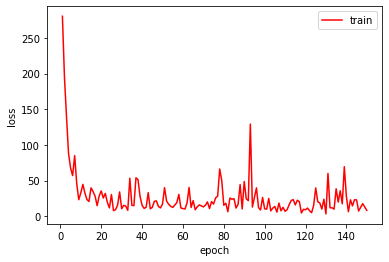

In [849]:
# Training on the full dataset

model_dir = os.path.join(out_dir, 'model-c')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

print('learning rate:', learning_rate)

print('START TRAINING...')

model = BrainAgeRegressor(num_age_bins=71, min_age=18, max_age=89).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []

for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img = batch_samples['img'].to(device)
        # Get the indexes of images in the batch
        img_idx = batch_samples['idx']

        optimizer.zero_grad()
        age_prediction = model(img)

        # Get the real age we want the network to predict
        truth = torch.as_tensor(y[img_idx], device=device, dtype=torch.float).view(-1,1)

        # Compute the loss as the MSE, while also computing the MAE for comparing with the other models
        loss = F.mse_loss(age_prediction, truth)
        mae = F.l1_loss(age_prediction, truth)
        loss.backward()
        optimizer.step()
        del img


    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tMAE: {:.6f}'.format(epoch, loss.item(), mae.item()))

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))
del model
torch.cuda.empty_cache()

print('\nFinished TRAINING...')
plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [850]:
# Select the test data indexes and files
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_test = [processing_dir + f + '.nii.gz' for f in ids_reg_test]

In [851]:
# Load the test data
dataset_test = GreyMatterDataset(files_reg_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:04<00:00, 23.16it/s]


Image: CC120640.nii.gz


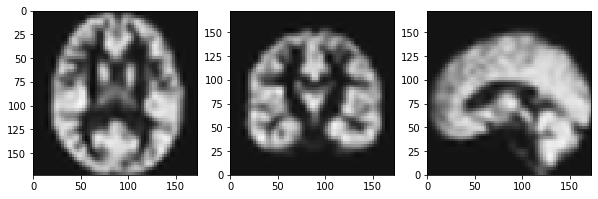

In [852]:
# Show a sample test image
sample = dataset_test.get_sample(1)
img_name = dataset_test.get_img_name(1)
print('Image: ' + img_name)
display_image(sample['img'])

# Compute the ground truth ages for testing
y_test = np.array(list(meta_data_reg_test['age']))

In [863]:
# Testing

pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model_dir = os.path.join(out_dir, 'model-c')
model = BrainAgeRegressor(num_age_bins=71, min_age=18, max_age=89).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
mae_test = 0
idx_test = 0

truth_test = np.array([])
predictions_test = np.array([])

with torch.no_grad():
    for data_sample in dataloader_test:
        img = data_sample['img'].to(device)
        # Get the index of image
        img_idx = data_sample['idx']
        
        age_prediction = model(img)
        truth = torch.as_tensor(y_test[img_idx], device=device, dtype=torch.float).view(-1,1)
        
        # Compute the loss as the MSE, while also computing the MAE for comparing with the other models

        loss_test += F.mse_loss(age_prediction, truth)
        mae_test += F.l1_loss(age_prediction, truth)
        
        # Save data for the regression plot
        truth_test = np.append(truth_test, truth.cpu().detach().numpy())
        predictions_test = np.append(predictions_test, age_prediction.cpu().detach().numpy())
        
        del img
        idx_test += 1
        
loss_test /= idx_test
mae_test /= idx_test


print('+ TESTING \tLoss: {:.6f} \tMAE: {:.6f}'.format(loss_test, mae_test))


print('\nFinished TESTING.')

START TESTING...
+ TESTING 	Loss: 30.683868 	MAE: 4.502922

Finished TESTING.


mean absolute error: 4.502921314239502
r2 score: 0.9188587793666443
explained variance: 0.9231296486680631


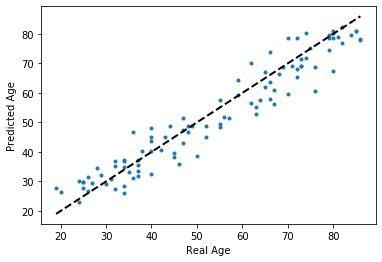

In [865]:
def evaluate(y, predicted):
    print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
    print('r2 score: {0}'.format(r2_score(y,predicted)))
    print('explained variance: {0}'.format(explained_variance_score(y,predicted)))
    
    fig, ax = plt.subplots()
    ax.scatter(y, predicted, marker='.')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')
    plt.show()

# Evaluate test set
evaluate(truth_test, predictions_test)